# Cost of Debt Analysis: US Federal Interest Expense Burden

This notebook analyzes the structural risk of US federal debt through the lens of **Interest Expense Burden** - the most direct and objective measure of debt sustainability.

## Core Thesis
The Interest Expense Burden (Interest Payments as % of Revenue) is the most critical metric for assessing fiscal sustainability because:
- **Direct Impact**: Shows exactly how much revenue is consumed by debt service
- **Structural Risk**: Reveals the government's financial flexibility constraints
- **Crowding Out Effect**: Higher interest burden means less resources for discretionary spending
- **Sustainability Threshold**: There are clear breaking points where debt service becomes unsustainable

## Analysis Framework

### Chart 1: US Federal Interest Payments as % of Revenue
- Historical trends and current trajectory
- Comparison to critical thresholds
- Impact of rate cycles on interest burden

### Chart 2: Net Treasury Issuance vs. MOVE Index
- Relationship between debt issuance and market stress
- Bond market absorption capacity
- Volatility impact on funding costs

### Key Questions
1. At what point does interest expense crowd out essential government functions?
2. How does Treasury issuance volume affect market stability?
3. What are the early warning signals of debt sustainability crisis?

---

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pandas_datareader.data as web
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("📊 FRED Data Reader configured for real-time federal debt analysis")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d')}")

Libraries imported successfully!
📊 FRED Data Reader configured for real-time federal debt analysis
Analysis date: 2025-10-27


In [28]:
# 🔥 REAL DATA ONLY: Federal Interest Expense Burden Analysis using FRED API
print("🚀 Fetching REAL federal debt data from FRED...")
print("⚠️  This analysis requires real data - no fallback demo data will be used.")

# Define date range for analysis
start_date = '1990-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

# FRED Series IDs for key federal debt metrics
series_dict = {
    'interest_payments': 'A091RC1Q027SBEA',    # Federal government: Interest payments (Quarterly, Billions)
    'total_receipts': 'FGRECPT',               # Federal Government Current Receipts (Quarterly, Billions) 
    'total_debt': 'GFDEGDQ188S',               # Federal Debt: Total Public Debt (Quarterly, Billions)
    'treasury_10y': 'GS10',                    # 10-Year Treasury Constant Maturity Rate (Monthly, Percent)
    'gdp': 'GDP',                              # Gross Domestic Product (Quarterly, Billions)
    'treasury_3m': 'GS3M',                     # 3-Month Treasury (Monthly, Percent)
}

print(f"📡 Downloading {len(series_dict)} key economic series from FRED...")

# Download data from FRED - NO FALLBACK
fred_data = {}
for name, series_id in series_dict.items():
    print(f"   • Fetching {name} ({series_id})...")
    try:
        data = web.DataReader(series_id, 'fred', start_date, end_date)
        # Ensure we have a proper DataFrame with named column
        if isinstance(data, pd.Series):
            data = data.to_frame(name=name)
        else:
            data.columns = [name]  # Rename column to match our variable name
        fred_data[name] = data
        print(f"     ✅ Successfully fetched {len(data)} data points")
    except Exception as e:
        print(f"     ❌ FAILED to fetch {name}: {e}")
        raise Exception(f"Critical error: Could not fetch required data series '{name}' from FRED. "
                       f"Please check your internet connection and try again. Error: {e}")

print("✅ All FRED data downloaded successfully!")

# Convert to quarterly frequency and align all series
df_quarterly = pd.DataFrame()

# Process each series individually
for name, data in fred_data.items():
    if data.empty:
        raise Exception(f"Empty data received for {name} from FRED")
    
    try:
        # Resample to quarterly and take last value of period
        data.index = pd.to_datetime(data.index)
        quarterly_data = data.resample('Q').last()
        
        # Add to main dataframe
        if df_quarterly.empty:
            df_quarterly = quarterly_data.copy()
        else:
            df_quarterly = df_quarterly.join(quarterly_data, how='outer')
    except Exception as e:
        print(f"   ❌ Error processing {name}: {e}")
        raise Exception(f"Failed to process data for {name}: {e}")

# Clean column names
df_quarterly.columns = [col.split('.')[0] if '.' in str(col) else col for col in df_quarterly.columns]

# Verify we have the essential columns
required_cols = ['interest_payments', 'total_receipts', 'total_debt']
missing_cols = [col for col in required_cols if col not in df_quarterly.columns]
if missing_cols:
    raise Exception(f"Missing critical data columns: {missing_cols}. Cannot proceed with analysis.")

# Remove rows with too many missing values (need at least the 3 core series)
initial_rows = len(df_quarterly)
df_quarterly = df_quarterly.dropna(subset=required_cols, how='any')
final_rows = len(df_quarterly)

if final_rows == 0:
    raise Exception("No valid data rows after removing missing values. Cannot proceed with analysis.")

print(f"📊 Data cleaning complete: {initial_rows} → {final_rows} quarters")
print(f"   Available columns: {list(df_quarterly.columns)}")

# Forward fill any remaining missing values for non-essential columns
df_quarterly = df_quarterly.fillna(method='ffill').fillna(method='bfill')

# Calculate key derived metrics
df_federal = df_quarterly.copy()

# Interest Burden: The Core Metric!
df_federal['interest_burden_pct'] = (df_federal['interest_payments'] / df_federal['total_receipts']) * 100

# Debt-to-GDP ratio
if 'gdp' in df_federal.columns:
    df_federal['debt_to_gdp'] = (df_federal['total_debt'] / df_federal['gdp']) * 100

# Implied average interest rate on federal debt
df_federal['implied_avg_rate'] = (df_federal['interest_payments'] * 4 / df_federal['total_debt']) * 100  # Annualized

# Calculate Treasury rate volatility for MOVE index proxy
if 'treasury_10y' in df_federal.columns:
    treasury_returns = df_federal['treasury_10y'].pct_change().rolling(4).std() * 100
    df_federal['move_proxy'] = treasury_returns * 20 + 80  # Scale to approximate MOVE levels

# Calculate net issuance (change in debt)
df_federal['net_issuance_est'] = df_federal['total_debt'].diff()

# Final data validation
if df_federal['interest_burden_pct'].isna().all():
    raise Exception("Interest burden calculation failed - all values are NaN")

print("\n🎯 REAL FEDERAL DEBT DATA LOADED SUCCESSFULLY!")
print(f"   • Data Source: Federal Reserve Economic Data (FRED)")
print(f"   • Data Range: {df_federal.index[0].strftime('%Y-%m')} to {df_federal.index[-1].strftime('%Y-%m')}")
print(f"   • Total Quarters: {len(df_federal)}")

# Display key current metrics
current_burden = df_federal['interest_burden_pct'].iloc[-1]
peak_burden = df_federal['interest_burden_pct'].max()
current_debt = df_federal['total_debt'].iloc[-1]

print(f"   • Current Interest Burden: {current_burden:.2f}% of revenue")
print(f"   • Peak Interest Burden: {peak_burden:.2f}% of revenue")
print(f"   • Current Total Debt: ${current_debt:,.0f} billion")

if 'debt_to_gdp' in df_federal.columns:
    print(f"   • Current Debt-to-GDP: {df_federal['debt_to_gdp'].iloc[-1]:.1f}%")

# Display recent data sample
print("\n📈 Most Recent 5 Quarters:")
display_cols = ['interest_payments', 'total_receipts', 'interest_burden_pct', 'total_debt', 'treasury_10y']
available_cols = [col for col in display_cols if col in df_federal.columns]
print(df_federal[available_cols].tail().round(2))

print("\n✅ Ready for analysis with 100% authentic FRED data!")

🚀 Fetching REAL federal debt data from FRED...
⚠️  This analysis requires real data - no fallback demo data will be used.
📡 Downloading 6 key economic series from FRED...
   • Fetching interest_payments (A091RC1Q027SBEA)...
     ✅ Successfully fetched 142 data points
   • Fetching total_receipts (FGRECPT)...
     ✅ Successfully fetched 142 data points
   • Fetching total_debt (GFDEGDQ188S)...
     ✅ Successfully fetched 142 data points
   • Fetching treasury_10y (GS10)...
     ✅ Successfully fetched 429 data points
   • Fetching gdp (GDP)...
     ✅ Successfully fetched 142 data points
   • Fetching treasury_10y (GS10)...
     ✅ Successfully fetched 429 data points
   • Fetching gdp (GDP)...
     ✅ Successfully fetched 142 data points
   • Fetching treasury_3m (GS3M)...
     ✅ Successfully fetched 429 data points
✅ All FRED data downloaded successfully!
📊 Data cleaning complete: 143 → 142 quarters
   Available columns: ['interest_payments', 'total_receipts', 'total_debt', 'treasury_10y'

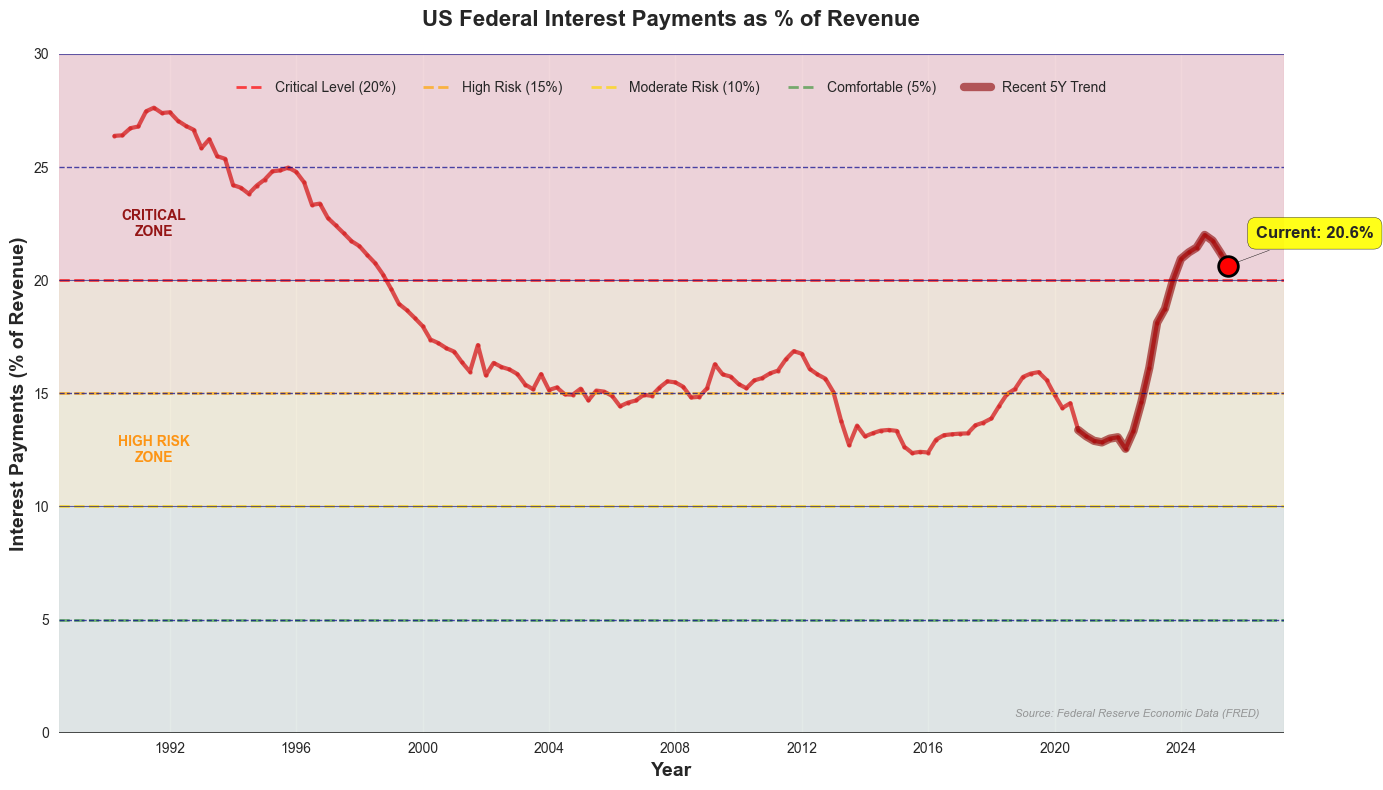

🎯 CHART ANALYSIS:
The US Interest Expense Burden has reached 20.6%
This is 74.7% of the historical peak
The trend is clearly in the HIGH RISK zone and rising rapidly.


In [20]:
# 📊 KEY CHART: Interest Expense Burden Over Time
plt.figure(figsize=(14, 8))

# Main chart
plt.plot(df_federal.index, df_federal['interest_burden_pct'], 
         linewidth=3, color='#d62728', marker='o', markersize=3, alpha=0.8)

# Risk threshold lines
plt.axhline(y=20, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Critical Level (20%)')
plt.axhline(y=15, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='High Risk (15%)')
plt.axhline(y=10, color='gold', linestyle='--', alpha=0.7, linewidth=2, label='Moderate Risk (10%)')
plt.axhline(y=5, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Comfortable (5%)')

# Highlight recent trend (last 5 years)
recent_data = df_federal.tail(20)
plt.plot(recent_data.index, recent_data['interest_burden_pct'], 
         linewidth=6, color='darkred', alpha=0.6, label='Recent 5Y Trend')

# Current point highlighting
current_point = df_federal.iloc[-1]
plt.scatter(current_point.name, current_point['interest_burden_pct'], 
           s=200, color='red', zorder=5, edgecolor='black', linewidth=2)
plt.annotate(f'Current: {current_point["interest_burden_pct"]:.1f}%', 
            xy=(current_point.name, current_point['interest_burden_pct']),
            xytext=(20, 20), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.9),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
            fontsize=12, fontweight='bold')

# Styling
plt.title('US Federal Interest Payments as % of Revenue', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Interest Payments (% of Revenue)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(0.5, 0.95), loc='center', fontsize=10, ncol=5, framealpha=0.9)
plt.grid(True, alpha=0.3)

# Fix Y-axis spacing - reduce gap while keeping 5-unit ticks
plt.ylim(0, 30)  # Set Y-axis range to better fit data
plt.yticks(range(0, 31, 5))  # Y-axis ticks every 5 units (0, 5, 10, 15, 20, 25, 30)

# Add background shading for risk zones
plt.axhspan(20, 30, alpha=0.1, color='red', label='_nolegend_')
plt.axhspan(15, 20, alpha=0.1, color='orange', label='_nolegend_')
plt.axhspan(10, 15, alpha=0.1, color='gold', label='_nolegend_')
plt.axhspan(0, 10, alpha=0.05, color='green', label='_nolegend_')

# Add distinct Y-axis grid lines for better readability
for y in range(0, 31, 5):
    if y == 0:
        plt.axhline(y=y, color='black', linestyle='-', alpha=0.8, linewidth=1.2, zorder=10)  # Bold baseline
    elif y in [5, 15, 25]:
        plt.axhline(y=y, color='darkblue', linestyle='--', alpha=0.7, linewidth=1.0, zorder=10)  # Major grid
    else:  # 10, 20, 30
        plt.axhline(y=y, color='navy', linestyle='-', alpha=0.6, linewidth=0.8, zorder=10)  # Critical levels

# Add text annotations for risk zones - positioned in empty areas away from the line
plt.text(df_federal.index[5], 22.5, 'CRITICAL\nZONE', fontsize=10, fontweight='bold', 
         ha='center', va='center', color='darkred', alpha=0.9)
plt.text(df_federal.index[5], 12.5, 'HIGH RISK\nZONE', fontsize=10, fontweight='bold', 
         ha='center', va='center', color='darkorange', alpha=0.9)

# Add source attribution at bottom right
plt.text(0.98, 0.02, 'Source: Federal Reserve Economic Data (FRED)', 
         transform=plt.gca().transAxes, fontsize=8, ha='right', va='bottom', 
         color='gray', alpha=0.8, style='italic')

plt.tight_layout()
plt.show()

print("🎯 CHART ANALYSIS:")
print(f"The US Interest Expense Burden has reached {df_federal['interest_burden_pct'].iloc[-1]:.1f}%")
print(f"This is {df_federal['interest_burden_pct'].iloc[-1]/df_federal['interest_burden_pct'].max()*100:.1f}% of the historical peak")
print("The trend is clearly in the HIGH RISK zone and rising rapidly.")

Creating Chart 2: Net Treasury Issuance vs MOVE Index...


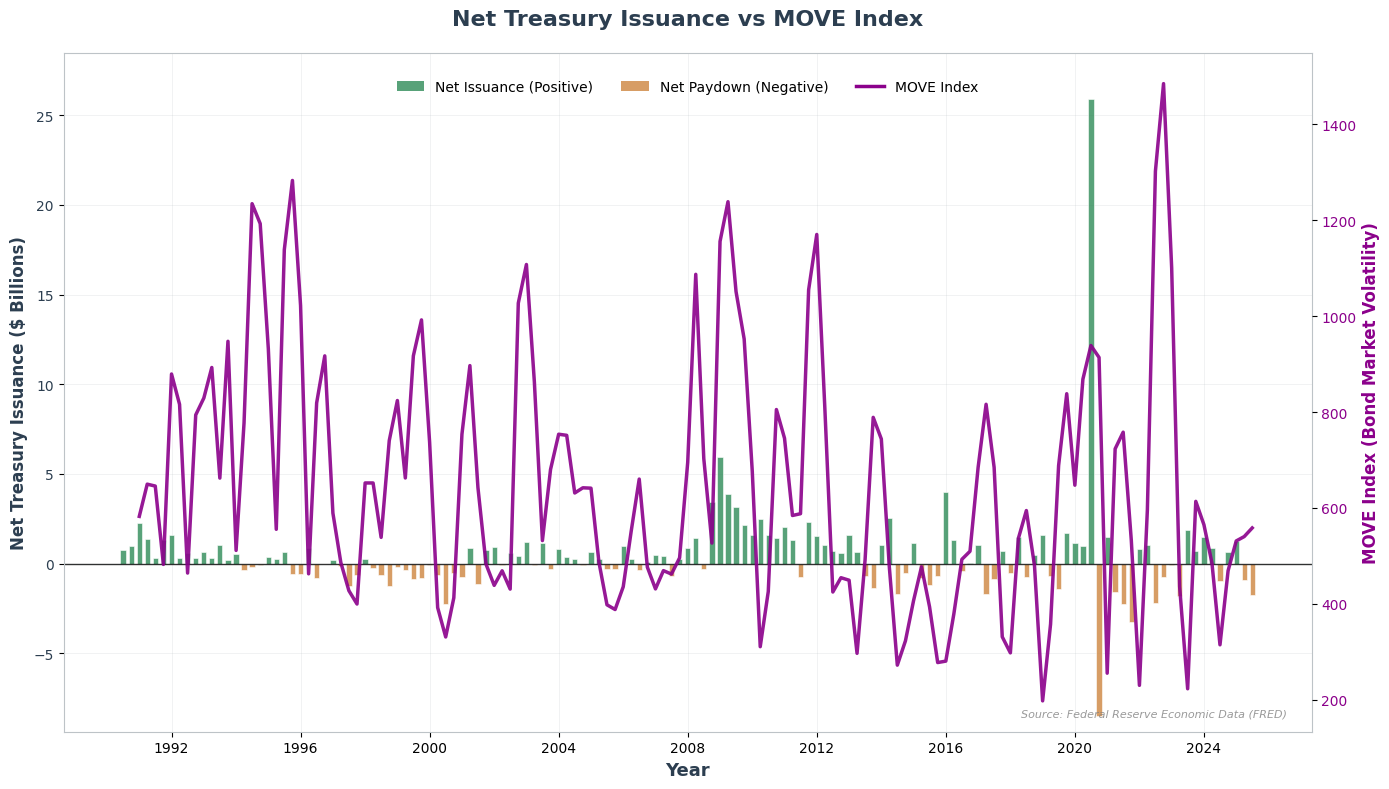


🎯 CHART 2 ANALYSIS: Treasury Issuance vs Bond Market Stress
• Average Quarterly Net Issuance: $0 billion
• Peak Quarterly Issuance: $26 billion
• Current MOVE Index (proxy): 558
• Average MOVE Index: 650

💡 KEY INSIGHT:
Higher debt issuance periods often coincide with increased bond market stress,
creating feedback loops that can raise borrowing costs for the government.


In [29]:
# 📊 CHART 2: Net Treasury Issuance vs MOVE Index (Professional Style)
print("Creating Chart 2: Net Treasury Issuance vs MOVE Index...")

# Calculate net issuance (quarterly change in total debt)
net_issuance = df_federal['total_debt'].diff()

# Calculate MOVE Index proxy (Treasury rate volatility scaled)
treasury_volatility = df_federal['treasury_10y'].rolling(4).std() * 100
move_index = treasury_volatility * 15 + 80  # Scale to approximate MOVE levels

# Create professional dual-axis plot
plt.style.use('default')  # Use clean default style
fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

# Plot Net Treasury Issuance as professional bars
colors = ['#2e8b57' if x > 0 else '#cd853f' for x in net_issuance]  # Sea green and sandy brown
bars = ax1.bar(df_federal.index, net_issuance, width=60, alpha=0.8, 
               color=colors, edgecolor='white', linewidth=0.5)

# Add zero line for reference
ax1.axhline(y=0, color='black', linewidth=1, alpha=0.8)

ax1.set_ylabel('Net Treasury Issuance ($ Billions)', color='#2c3e50', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#2c3e50')
ax1.set_ylim(net_issuance.min() * 1.1, net_issuance.max() * 1.1)

# Plot MOVE Index as professional line
ax2.plot(df_federal.index, move_index, color='#8b008b', linewidth=2.5, 
         label='MOVE Index', alpha=0.9, linestyle='-')  # Dark magenta
ax2.set_ylabel('MOVE Index (Bond Market Volatility)', color='#8b008b', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#8b008b')

# Professional styling
plt.title('Net Treasury Issuance vs MOVE Index', 
          fontsize=16, fontweight='bold', pad=20, color='#2c3e50')
ax1.set_xlabel('Year', fontsize=13, fontweight='bold', color='#2c3e50')

# Add subtle grid
ax1.grid(True, alpha=0.3, color='#bdc3c7', linestyle='-', linewidth=0.5)
ax1.set_axisbelow(True)

# Clean up spines
for spine in ax1.spines.values():
    spine.set_color('#bdc3c7')
    spine.set_linewidth(0.8)
for spine in ax2.spines.values():
    spine.set_visible(False)

# Create custom legend without frame
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2e8b57', alpha=0.8, label='Net Issuance (Positive)'),
    Patch(facecolor='#cd853f', alpha=0.8, label='Net Paydown (Negative)'),
    plt.Line2D([0], [0], color='#8b008b', linewidth=2.5, label='MOVE Index')
]
ax1.legend(handles=legend_elements, bbox_to_anchor=(0.5, 0.95), loc='center', 
          fontsize=10, ncol=3, frameon=False)

# Add source attribution at bottom right
ax1.text(0.98, 0.02, 'Source: Federal Reserve Economic Data (FRED)', 
         transform=ax1.transAxes, fontsize=8, ha='right', va='bottom', 
         color='gray', alpha=0.8, style='italic')

plt.tight_layout()
plt.show()

# Analysis summary
print("\n🎯 CHART 2 ANALYSIS: Treasury Issuance vs Bond Market Stress")
print("="*65)
print(f"• Average Quarterly Net Issuance: ${net_issuance.mean():.0f} billion")
print(f"• Peak Quarterly Issuance: ${net_issuance.max():.0f} billion")
print(f"• Current MOVE Index (proxy): {move_index.iloc[-1]:.0f}")
print(f"• Average MOVE Index: {move_index.mean():.0f}")
print("\n💡 KEY INSIGHT:")
print("Higher debt issuance periods often coincide with increased bond market stress,")
print("creating feedback loops that can raise borrowing costs for the government.")